# Heat Transfer Problem

Consider the heat transfer problem:

$$
u_t - u_{xx} = f(x,t), \quad (x, t) \in (0, 1) \times (0, 1)
$$

with the following initial and boundary conditions:

- Initial condition:  
  $$
  u(x, 0) = \sin(\pi x)
  $$

- Dirichlet boundary conditions:  
  $$
  u(0, t) = u(1, t) = 0
  $$

and the source function:

$$
f(x, t) = (\pi^2 - 1)e^{-t}\sin(\pi x)
$$

#### Analytic Solution

The analytic solution to this problem is given by:

$$
u(x, t) = e^{-t} \sin(\pi x)
$$

# Forward Euler Code


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt

# forcing function
def f(x, t):
    return  (np.pi**2 - 1) * np.exp(-t) * np.sin(np.pi * x)

# stiffness and mass matrix assembly
def K_M(N, h):
    Ne = N - 1
    K = np.zeros((N, N))
    M = np.zeros((N, N))

    for k in range(Ne):
        mlocal = np.zeros((2, 2))
        klocal = np.zeros((2, 2))

        for l in range(2):
            for m in range(2):
                klocal[l, m] = -1 / h if l != m else 1 / h
                mlocal[l, m] = h / 6 if l != m else h / 3

        # global stiffness/mass matrix assembly
        for l in range(2):
            globalnode1 = k + l
            for m in range(2):
                globalnode2 = k + m
                K[globalnode1, globalnode2] += klocal[l, m]
                M[globalnode1, globalnode2] += mlocal[l, m]

    return K, M

# applying dirichlet boundary conditions
def apply_dirichlet_bc(K, F, u_db, dirichlet_nodes):
    for i in dirichlet_nodes:
        for j in range(K.shape[0]):
            if i != j:
                F[j] -= K[j, i] * u_db[i]
                K[j, i] = 0  # Set column to zero
                K[i, j] = 0  # Set row to zero
        K[i, i] = 1
        F[i] = u_db[i]
    return K, F

# boundary conditions 
def u_boundary(x):
    return np.sin(np.pi * x)

# analytic solution to given problem -- used for rechecking
def u_solution(x,t):
    return np.sin(np.pi * x)*np.exp(-t)

def FEM(method = "FE", N = 11, dt = 1/551, plot = True):
    if N <2:
        print("Need at least 2 nodes to perform FEM")
        return "ERROR"
    
    xi = np.linspace(0, 1, N)
    h = xi[1] - xi[0]
    
    tf = 1
    t0 = 0
    nt = int((tf - t0) / dt)
    ctime = t0

    K, M = K_M(N, h)

    M_inv = np.linalg.inv(M)
    dx_de = h / 2

    phi = lambda eta: [(1 - eta) / 2, (1 + eta) / 2]
    quad_points = [-1/sqrt(3), 1/sqrt(3)]
    quad_weights = [1,1]

    u = np.zeros((N, nt + 1))  # Time-dependent solution array
    u[:, 0] = u_boundary(xi)
    
    # Set Dirichlet boundary conditions
    u_db = np.zeros(N)  # Prescribed values (e.g., zero at boundaries)
    dirichlet_nodes = [0, N - 1]  # Dirichlet nodes at boundaries

    # constructing F vector
    for n in range(nt):
        ctime = t0 + n * dt
        F = np.zeros(N)

        for k in range(N - 1):
            flocal = np.zeros(2)

            for l in range(2):
                for p in range(len(quad_points)):
                    if method =="FE":
                        flocal[l] += f((h / 2) * (quad_points[p] + 1) + xi[k], ctime) *phi(quad_points[p])[l] * quad_weights[p]  * dx_de 
                    else: # backward euler, evaluate at next/future time step
                        flocal[l] += f((h / 2) * (quad_points[p] + 1) + xi[k], ctime+dt) *phi(quad_points[p])[l] * quad_weights[p]  * dx_de 

            for l in range(2):
                globalnode = k + l
                F[globalnode] += flocal[l]

        if method == 'FE':
            # Apply Dirichlet boundary conditions to K and F
            K_bc, F_bc = apply_dirichlet_bc(K.copy(), F.copy(), u_db, dirichlet_nodes)
            u[:,n + 1] = u[:,n] - dt * M_inv @ K_bc @ u[:,n] + dt * M_inv @ F_bc
        else:
            B = M + dt * K  # System matrix
            b = M @ u[:, n] + F * dt  # Right-hand side vector
        
            # Apply Dirichlet boundary conditions to A and b
            B_bc, b_bc = apply_dirichlet_bc(B.copy(), b.copy(), u_db, dirichlet_nodes)

            # Solve for the next timestep
            u[:, n + 1] = np.linalg.solve(B_bc, b_bc)

    if plot:
        plt.scatter(xi,u[:,-1],label = f"{method} FEM solution", color = "darkgreen")
        plt.plot(xi,u[:,-1], label = f"linear interpolation of {method} FEM", color = "red", linewidth = 3)
        plt.plot(np.linspace(0,1,100), u_solution(np.linspace(0,1,100),tf), label = "analytic solution",color = "black")
        plt.legend()
        plt.show()
    # print("RMSE", np.linalg.norm(u_solution(xi,tf)- u[:,-1]))
    mae =  np.sum(np.abs(u_solution(xi,tf)- u[:,-1]))
    return K,F

## Question 2 
Solve first by using a forward Euler time derivative discretization with a time-step of $\Delta t = 1/551$. Plot the results at the final time. Increase the time-step until you find the instability. What dt does this occur at? How does the solution change as N decreases?

*Note: all plots are done at the final time, $t = 1$.

### 2.1: Forward Euler time discretization with time spacing $\Delta t = 1/551$ and number of nodes $N = 11$

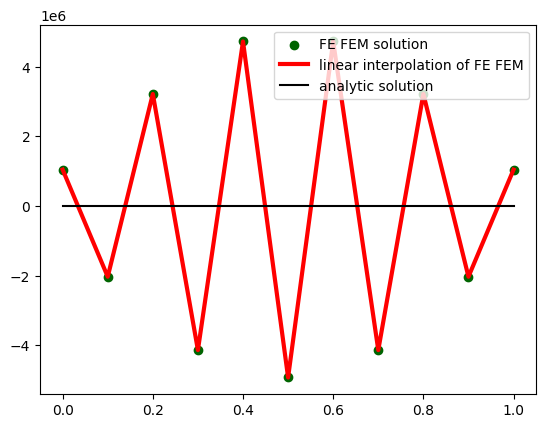

35246303.03182401

In [28]:
FEM("FE",N =11, dt = 1/551)
  

A time step of $1/551$ leads to an unstable FEM solution. We decrease the time step to find stability:

### 2.2: Forward Euler FEM solution with time discretization variation

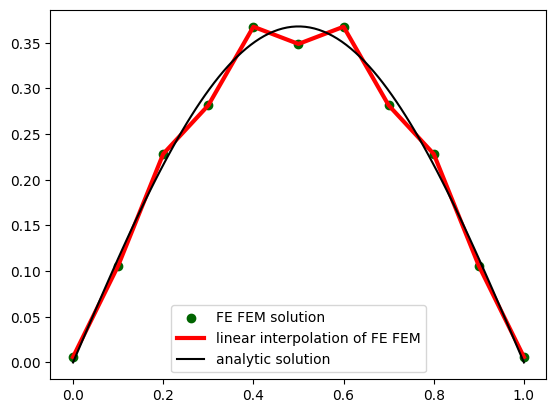

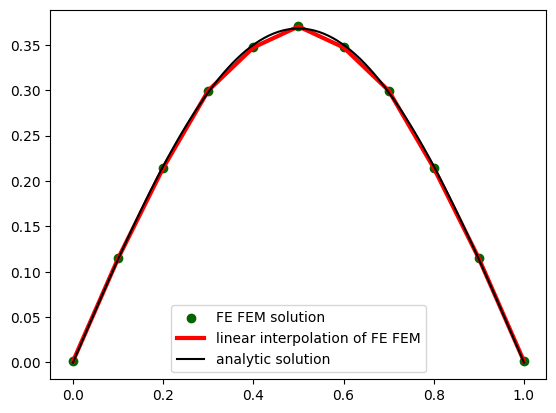

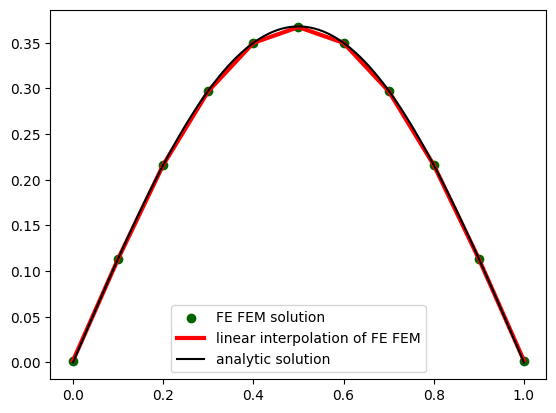

0.006561129354341543

In [29]:
FEM("FE",N =11, dt = 1/561)
FEM("FE",N =11, dt = 1/562)
FEM("FE",N =11, dt = 1/563)

We notice stability of the FEM solution for a timestep $\Delta t \gt 1/561$.

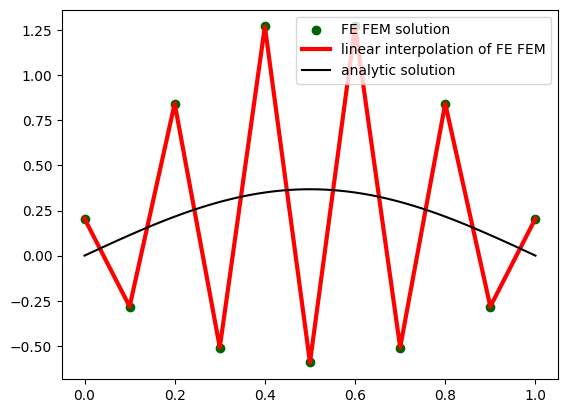

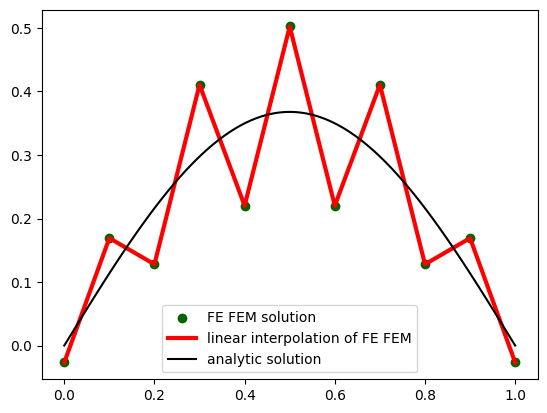

0.9607466929307952

In [30]:
FEM("FE",N =11, dt = 1/559)
FEM("FE",N =11, dt = 1/560)

Additionally, we notice instability of the FEM solution for a timestep $\Delta t \lt 1/561$. Thus, the instibility cut-off roughly occurs at a step size of $\Delta t = 1/561$, with any larger time steps leading to instability. 

### 2.3: Forward Euler FEM solution with spatial discretization variation

spatial elements, N = 11


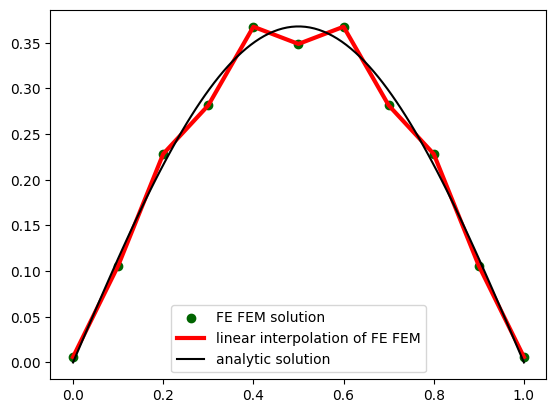

spatial elements, N = 9


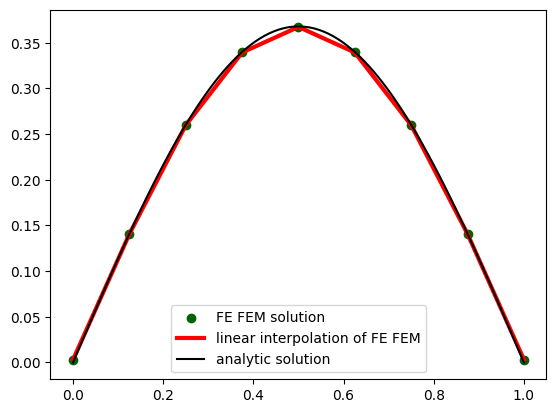

spatial elements, N = 7


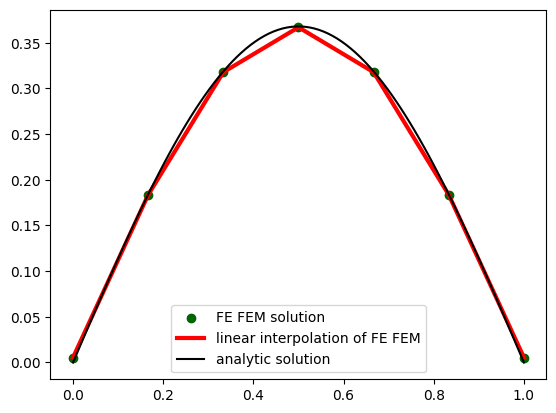

spatial elements, N = 3


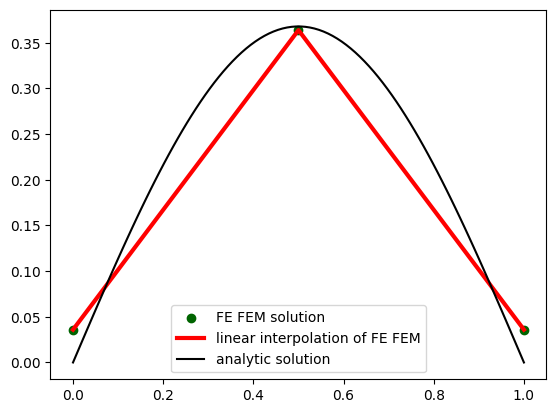

spatial elements, N = 2


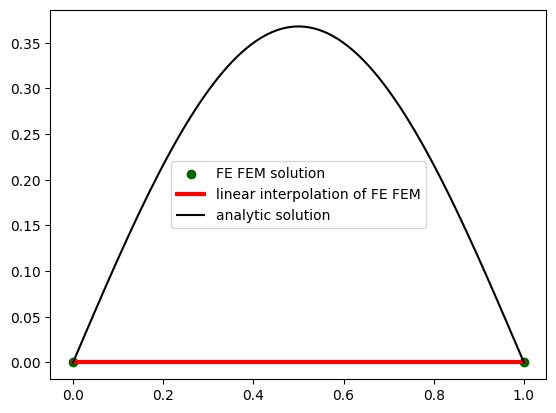

spatial elements, N = 1
Need at least 2 nodes to perform FEM


In [31]:
for N in list(range(11, 5, -2)) + [3, 2, 1]:
    print(f"spatial elements, N = {N}")
    FEM("FE", N, dt=1/561)


There are 2 effects of decreasing the number of spatial discretizations:
1. As the the spatial discretization coarsens, the solution increases in stability -- a larger time discritization can be used. This is demonstrated further below. For $ N = 20, \Delta t =1/2100$ leads to an unstable solution, but for $N=19, \Delta t=1/2100$ leads to a stable solution. Notice that a finer spatial discrization requires a finer time discritization. 
2. Additionally, the prediction accuracy decreases--while nodal accuracy (solution evaluation at nodes) remains high, a linear solution interpolation between nodes becomes more erraneous. This is further shown when calling the FEM with 2 or 1 spatial nodes. For $N  = 2 $, we notice that only the two boundary conditions are satisfied, and for $ N =1$, the FEM cannot be applied.  

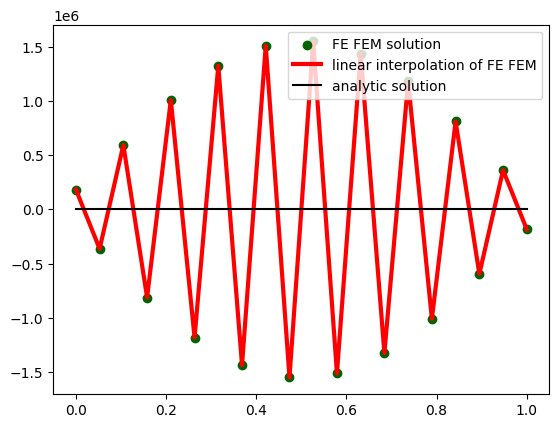

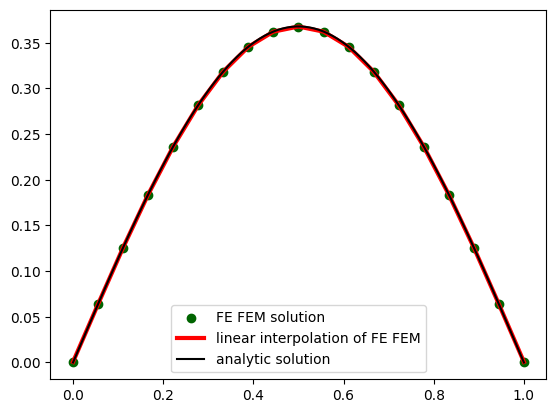

0.002509755029599544

In [32]:
FEM("FE",N =20, dt = 1/2100)
FEM("FE",N =19, dt = 1/2100)

## Question 3
Solve the same problem with the same time-steps using an implicit
backward Euler. What happens as the time-step is equal to or greater than
the spatial step size? Explain why.


### 3.1: Backward Euler time discritization with $\Delta t = 1/551$ and $N = 11$

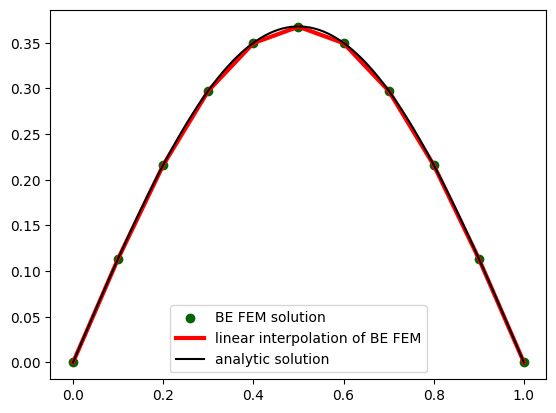

0.001889693889565714

In [33]:
FEM("BE",N = 11, dt = 1/551)

### 3.2: Backward Euler with time step size greater than spatial step size


As the time step increases to be equal to or greater than the spatial step size, the error increases; specifically, the FEM solution has an increased curvature (higher peak) than the analytic solution. This is shown with the below 3 plots. 

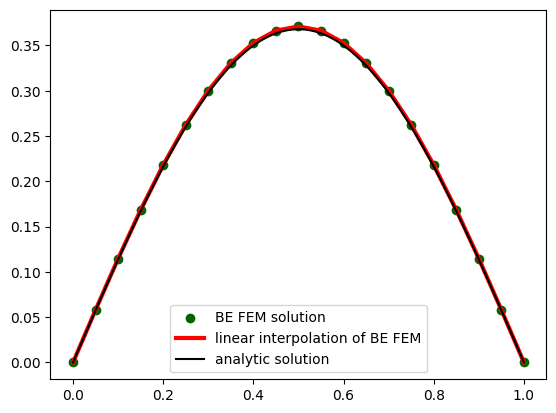

MAE: 0.0384367897445019


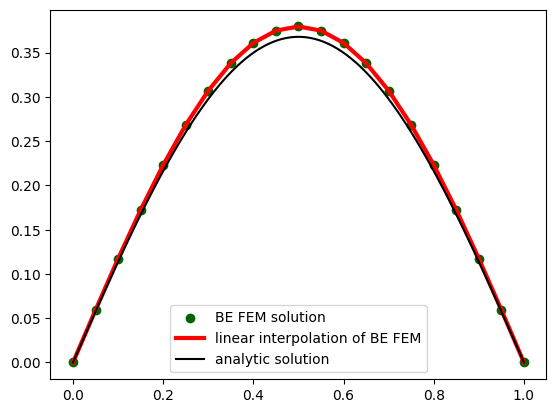

MAE: 0.14833362523486437


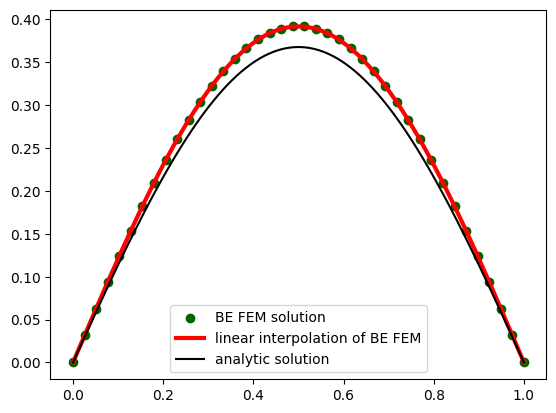

MAE: 0.6024988822107951


In [12]:

print("MAE:", FEM("BE",N = 21, dt =1/7))
print("MAE:", FEM("BE",N = 21, dt =1/2))
print("MAE:", FEM("BE",N = 40, dt =1))

Note that for the Backward Euler discretization, we solve $(M + \Delta t K) u_{n+1} = M u_n + \Delta t F$. Thus, when $\Delta t$ is increased, the term $\Delta t K$ increases in magnitude; the weight/influence of the $K$ matrix increases. Recall that $K$ is directly related to the $u_{xx}$ or the curvature of the solution:
In the weak form of the heat equation, $u_{xx}$ appears as the term:

$$
-\int_0^1 u_{xx} \phi_i \, dx.
$$

With Integration by parts, 

$$
-\int_0^1 u_{xx} \phi_i \, dx = \int_0^1 u_x \frac{\partial \phi_i}{\partial x} \, dx - \left[ u_x \phi_i \right]_0^1.
$$

Note that the boundary term may be canceled for homogeneous boundary conditions, but regardless:
This leaves:

$$
-\int_0^1 u_{xx} \phi_i \, dx \approx \int_0^1 \frac{\partial \phi_i}{\partial x} \frac{\partial u}{\partial x} \, dx + ...
$$
With Gaussian quadrature:
$$
\frac{\partial u}{\partial x} \approx \sum_j U_j \frac{\partial \phi_j}{\partial x},
$$

$$
\int_0^1 \frac{\partial \phi_i}{\partial x} \frac{\partial u}{\partial x} \, dx = \sum_j U_j \int_0^1 \frac{\partial \phi_i}{\partial x} \frac{\partial \phi_j}{\partial x} \, dx = \sum_j U_j K_{ij},
$$

Thus, the magnitude of $K$ is proportional to the magnitude of $u_xx$. When $\Delta t$ is increased, the effect is equivalent to the $K$ matrix being scaled, which in turn relates to the increased $u_xx$ or curvature. 


[0.0010536184512452036, 0.0020523953219557974, 0.07542597592661628, 0.038391530819705054, 0.18908851089863143, 0.24327333103774634, 0.19864704978262046, 0.10592112189790695, 0.20634267363940662, 0.06539713659457333, 0.5158413716319645, 0.07203746902287085, 0.22001035212918296, 0.47451982985418467, 0.12944197499325655, 0.533093635382009, 0.2329699134321575, 0.8071408285034691, 0.5431979166168466, 0.2919819554199535, 1.0989405505207146, 0.8762617479976436, 0.6621924697395386, 0.4563997121286855, 0.258563296681708, 1.413111666454509, 1.2372585687409434, 1.066510899799572, 0.9007201034044469, 0.7397419465166138, 0.5834363913098786, 0.4316674719949871, 0.2843031759454764, 0.1412153287494435, 1.8868952057223922, 1.7615306042436785, 1.6385931496913393, 1.5180354433450918, 1.399811030944093, 1.2838743811429065, 1.1701808649260683, 1.0586867358647802, 0.9493491111188508, 0.8421259531068737, 0.736976051777544, 0.633859007429007, 0.5327352140301038, 0.43356584300564166, 0.3363128274528761, 0.2409

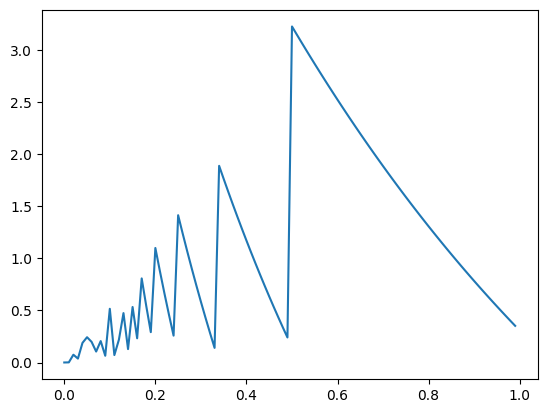

In [45]:
rmses=[]
for i in np.arange(.0001,1,.01):
    rmse = FEM("BE", N=21, dt = i, plot = False)
    rmses +=[rmse]
plt.plot(np.arange(.0001,1,.01),rmses)
print(rmses)

In [ ]:
def f(x, t=1):
    return  (np.pi**2 - 1) * np.exp(-t) * np.sin(np.pi * x)
print(f(np.linspace(0,1,100)).shape)
K, M = K_M(100, 1/100)
print(np.linalg.inv(K)@F)
plt.scatter(np.linspace(0,1,100), np.linalg.inv(K)@f(np.linspace(0,1,100)))
plt.show()

(100,)
[[ 100. -100.    0. ...    0.    0.    0.]
 [-100.  200. -100. ...    0.    0.    0.]
 [   0. -100.  200. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...  200. -100.    0.]
 [   0.    0.    0. ... -100.  200. -100.]
 [   0.    0.    0. ...    0. -100.  100.]]


LinAlgError: Singular matrix